In [1]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

In [4]:
#Read the image
refFilename = 'form.jpg'
print("Reading reference image : ", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

#Read the image to be aligned
imFilename = 'scanned-form.jpg'
print("Reading image to align : ", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg


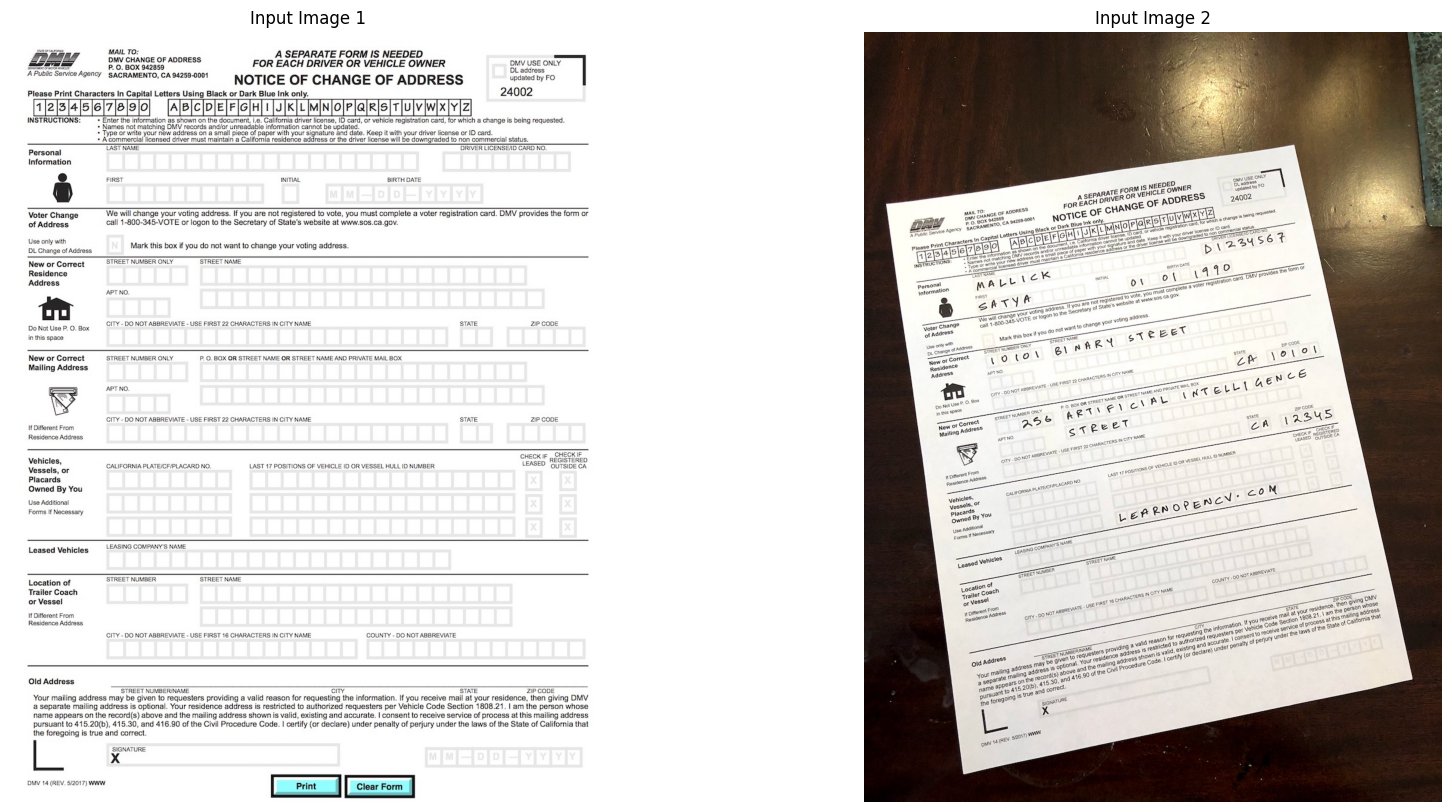

In [5]:
#Display input images
plt.figure(figsize=(20,10))
plt.subplot(121);plt.axis('off');plt.title("Input Image 1");plt.imshow(im1)
plt.subplot(122);plt.axis('off');plt.title("Input Image 2");plt.imshow(im2)

Step 2: Find keypoints in both Images
Think of keypoints as corner points that are stable under image transformations

In [25]:
#Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_RGB2GRAY)

#Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
#explanation of the parameters: https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html 
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)
#what this function does: https://docs.opencv.org/3.4/d7/dff/tutorial_feature_homography.html
#keypoints are the points of interest in the image, format is (x,y,angle,scale)
#descriptors are the features of the keypoints, format is matrix
print(keypoints1[0].size)
print(descriptors1.shape)

#Display detected keypoints.
im1_display = cv2.drawKeypoints(im1,keypoints1, outImage=np.array([]),color=(255,0,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2,keypoints2, outImage=np.array([]),color=(255,0,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

31.0
(500, 32)


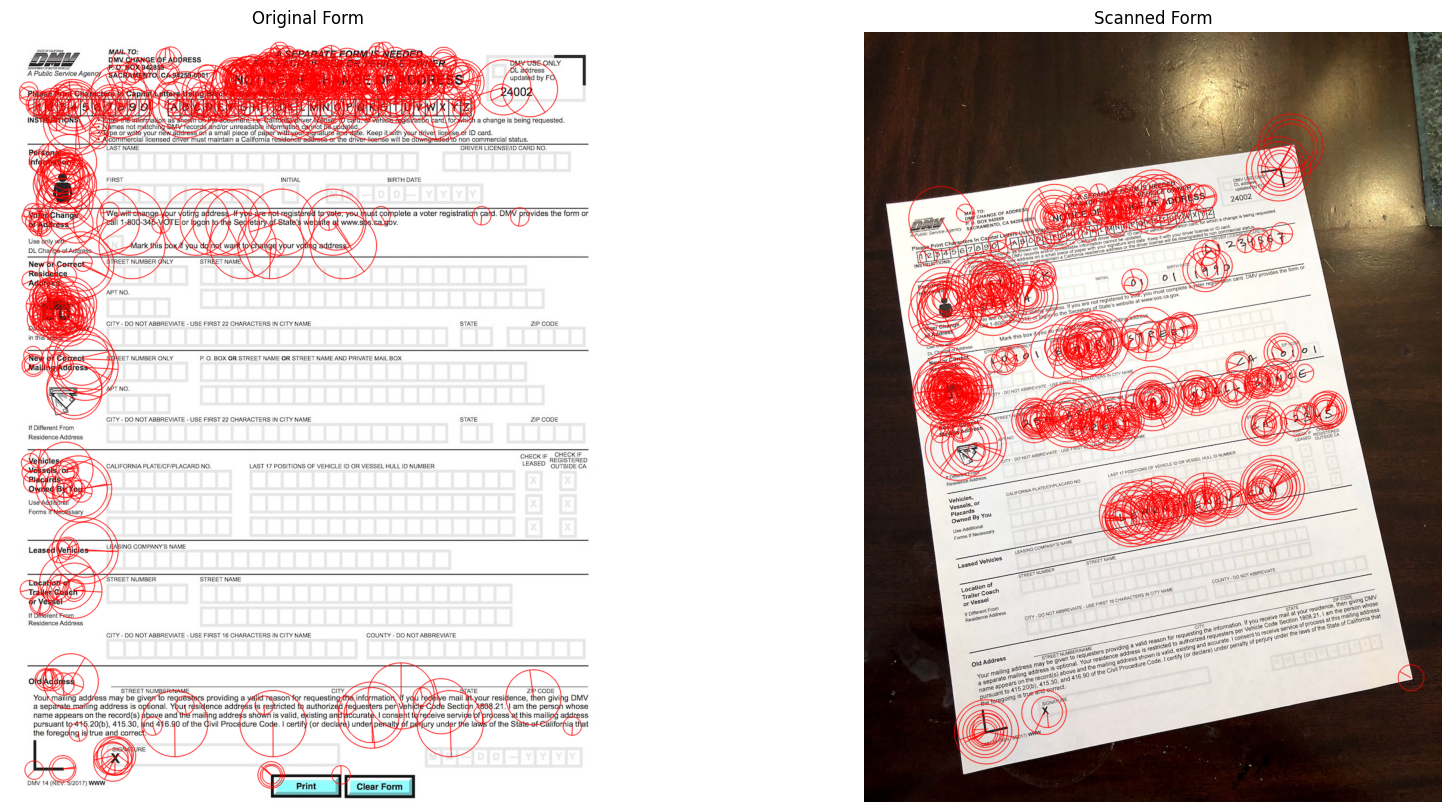

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(121);plt.axis('off');plt.title("Original Form");plt.imshow(im1_display)
plt.subplot(122);plt.axis('off');plt.title("Scanned Form");plt.imshow(im2_display)

#explain the keypoints in first image
#centre of the circle is the x,y coordinate of the keypoint
#radius of the circle is the scale of the keypoint
#line is the angle of the keypoint

In [36]:
#MAtch features between the two images.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#explanation DescriptorMatcher_create: https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html
matches = list(matcher.match(descriptors1,descriptors2, None))
#explanation of parameters 
#descriptors1: descriptors from the first image
#descriptors2: descriptors from the second image
#None: mask to indicate which matches are valid. If it is empty, all matches are valid
# print(matches)
#sOrt matches by score
matches.sort(key=lambda x:x.distance, reverse=False)
#explanation of the sort function: https://www.geeksforgeeks.org/ways-sort-list-dictionaries-values-python-using-lambda-function/

#Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]


(-0.5, 1999.5, 1332.5, -0.5)

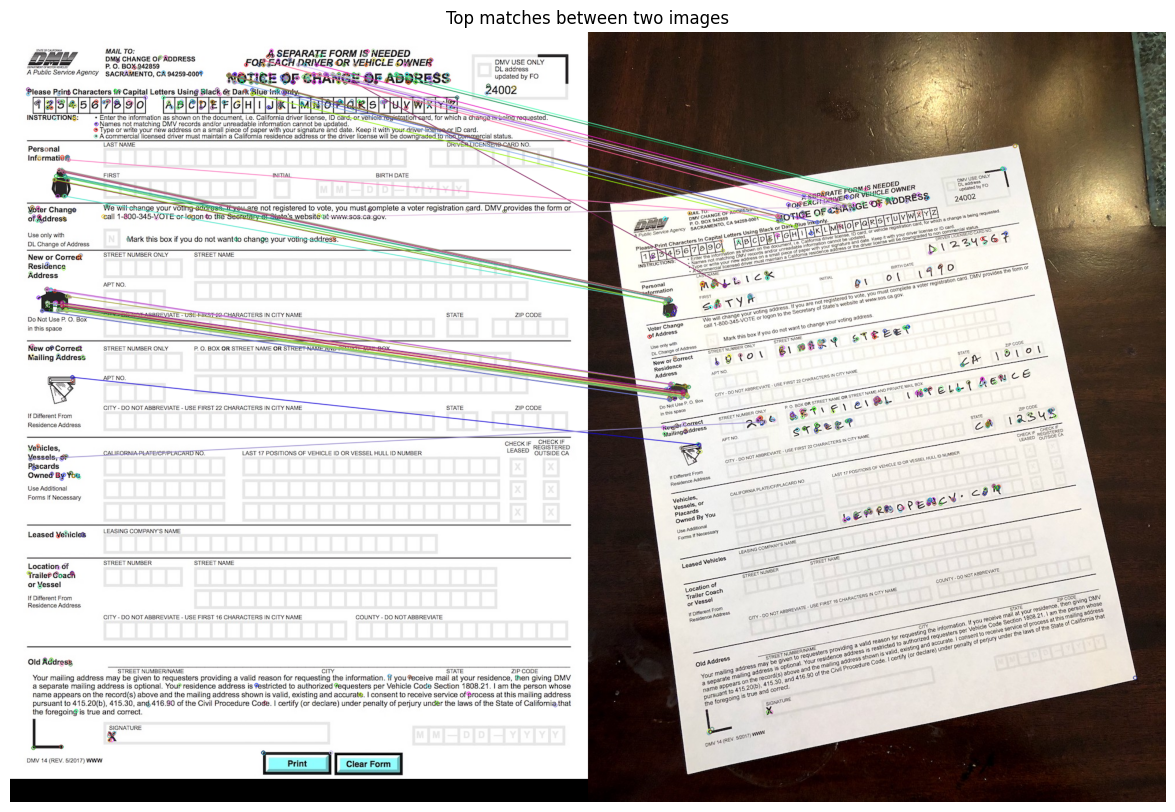

In [37]:
#Draw top matches
im_matches = cv2.drawMatches(im1,keypoints1,im2,keypoints2,matches, None)
#explanation of the parameters: https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html
plt.figure(figsize=(20,10))
plt.imshow(im_matches);plt.title("Top matches between two images");plt.axis('off')

In [52]:
#Finding homography
#HomoGraphy is a transformation matrix that maps the points in one image to the corresponding points in the other image
#Explaination of the function: https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html
points1 = np.zeros((len(matches),2),dtype=np.float32)
points2 = np.zeros((len(matches),2),dtype=np.float32)

#need to convert the keypoints into numpy array
for i, match in enumerate(matches):
    # print(match.queryIdx, match.trainIdx)
    points1[i,:] = keypoints1[match.queryIdx].pt
    points2[i,:] = keypoints2[match.trainIdx].pt
    #queryIdx: index of the keypoint in the first image
    #trainIdx: index of the keypoint in the second image
    
#Find homography
h, mask = cv2.findHomography(points2,points1,cv2.RANSAC)
#make sure the points are in the correct format and the correct order
# print(h)

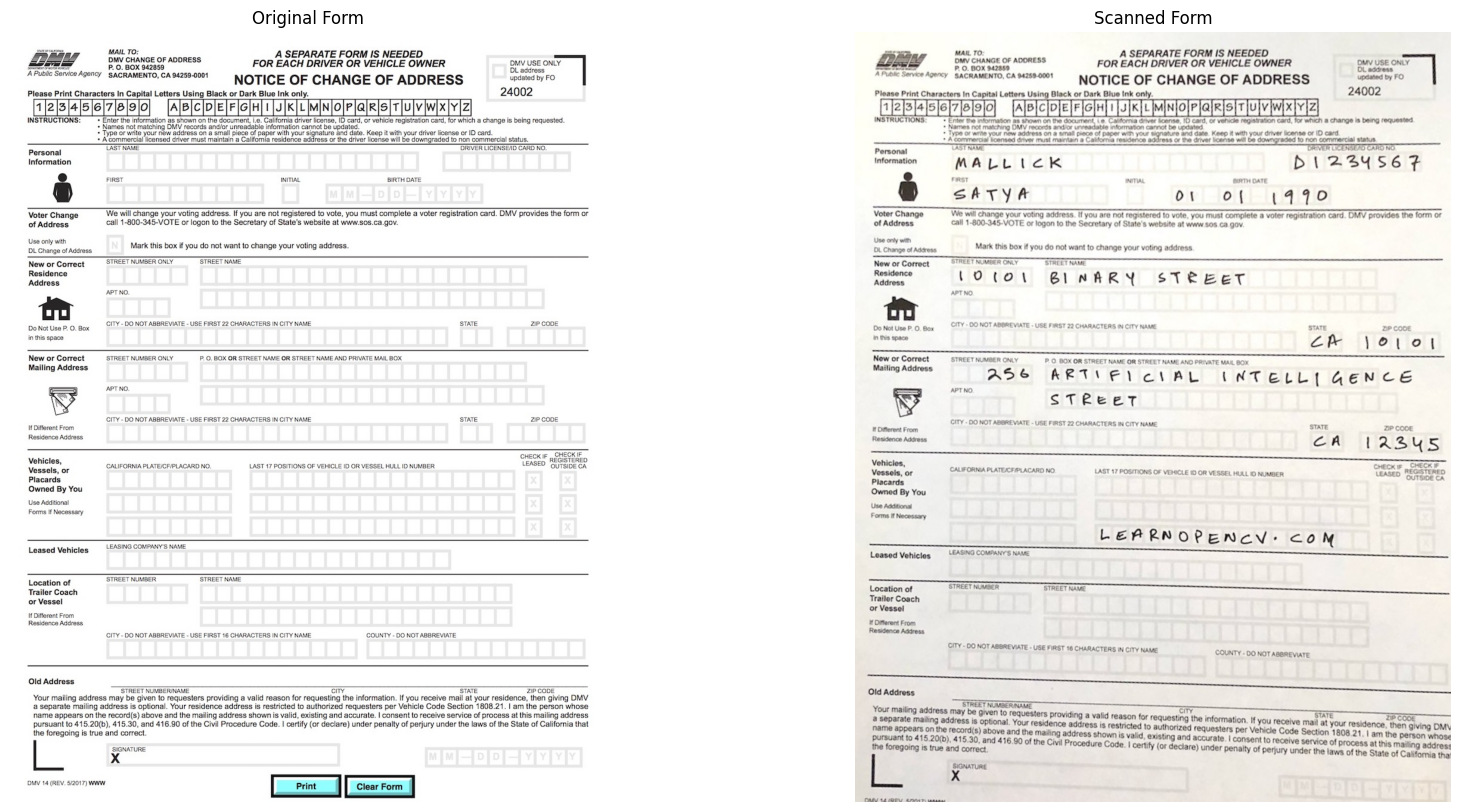

In [53]:
#Warp source image to destination based on homography
height,width,channels = im1.shape
# print(height,width,channels)
im2_reg = cv2.warpPerspective(im2,h,(width,height))
#explanation of the function: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga20f62aa55d2ca5c05d707e7f5bbdde7d 


#Display registered image
plt.figure(figsize=(20,10))
plt.subplot(121);plt.axis('off');plt.title("Original Form");plt.imshow(im1)
plt.subplot(122);plt.axis('off');plt.title("Scanned Form");plt.imshow(im2_reg)